# Welcome to dymoval's tutorial!
 
In this tutorial we show the main functionalities of *dymoval*. In particular we will show:

- How to clean up a measurement dataset,
- How to use such a dataset for validating our model. 

## DC Motor model
We assume that we developed the model of a DC electric motor. Now we want to validate it. The motor is assumed to be connected to a constant load.
The modeled dynamics represent the interaction between DC voltage that is interpreted as *input* and the motor speed and the DC current that are considered as *outputs*.

<p align="center">
    <br>
  <img src="./DCMotor.svg" width="750" title="DCMotor" class="center">
</p>


### Validation setup
To validate our model we need to verify that its response is as close as possible to the actual DC motor response in front of the same *input* signal. Therefore, we need to log some **measurement data** and use them to stimulate our model, thus generating some **simulation data**. Both measurements and simulation data serve as inputs to Dymoval.

We assume that we get some measurements logs from a team that ran some experiments in some lab. They collected the logs in a `HDF5` file. To make a scenario more realistic, we also assume that another team developed the DC motor model. 

## Log data clean-up
The first step is to extract the logs from the `HDF5` file and build a *dymoval* Dataset object. For achieving such a goal let us import some useful - and fairly standard packages:

In [1]:
# %matplotlib widget # requires ipympl package
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
from itertools import product
import dymoval as dmv
import matplotlib

# set max number of decimals
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = lambda x: f"{x:.4f}"


>**Note:**
>If your notebook supports interactive plots, then you may uncomment the first line of the above code cell. 

Let's read the log data stored in the `hdf5` file. All the logs that we are interested in are stored in the group "*signals*".
Feel free to explore the hdf5 file at your convenience.
We use the `h5py` package to read it, but feel free to explore any other package that can read HDF5 files.

In [2]:
logs = h5py.File('./signals.h5', 'r')
logs["signals"].keys()

<KeysViewHDF5 ['Ia', 'V', 'motor_speed']>

We extract the logged signals as it follows (see *h5py* docs for more info):

In [3]:
V = logs["signals/V"] # Measured supply voltage (input)
Ia = logs["signals/Ia"] # Measured current (output)
motor_speed = logs["signals/motor_speed"] # Measured motor rotational speed (output)

To begin with, we map the measured valued into *dymoval* `Signals`. 
Dymoval's `Signals` are  Python `dict` (in reality they are `Typeddict`) with keys `name`, `samples`, `signal_unit`, `sampling_period` and `time_unit` which are  quantities that typically chracterize a physical signal. 

In [4]:
signal_list = []
for val in [V,Ia, motor_speed]:
    temp:dmv.Signal={
        "name" : val.attrs["name"],
        "samples" : val[:],
        "signal_unit" : val.attrs["unit"],
        "sampling_period" : val.attrs["period"],
        "time_unit" : val.attrs["sampling_unit"],
    }
    signal_list.append(deepcopy(temp))


Our variable `signal_list` is a list of Signals.
Let's see how they look like:

/home/yt75534/dymoval/src/dymoval/dataset.py:3096: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


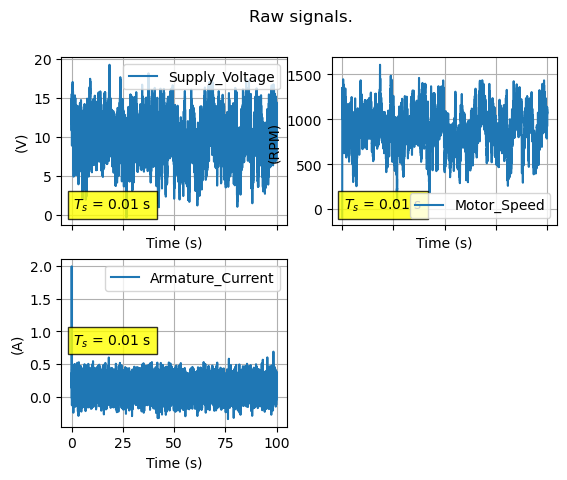

In [5]:
_= dmv.plot_signals(*signal_list)

As we can see, the signals have not been logged with the same sampling period and there is also some missing data.
Well, things happen in the lab!

Nevertheless, a sound dataset shall have all the signals sampled with the same sampling period and it should not contains missing data. 
We can trim the signals in the time range e.g. $T = [40,75]\,s$ which seems a portion where no signal is missing data.

Finally, we can separate input and output signals and we can attempt to re-sample all of them with target sampling period equal to $0.01\,s$. The cleaned-up signals will represent our Dataset that we will use for model validation. 

In [6]:
signal_names = [s["name"] for s in signal_list]
u_names = signal_names[0]
y_names = signal_names[1:]
ds = dmv.Dataset(
    "DCMotor",
    signal_list,
    u_names,
    y_names,
    target_sampling_period=0.01,
    tin = 40,
    tout = 75.0
)

When creating a dymova *Dataset* object, the signals are always re-sampled in such a way that all of them will have the same sampling period, but sometimes this is not possible and therefore some signals may be excluded from the Dataset. 

The list of the excluded signals are stored in the attibute `excluded_signal`.

In [7]:
ds.excluded_signals

[]

The list is empty, which means that all the signals have been correctly re-sampled.

Let's now take a look at how our Dataset looks like based on our selection:

/home/yt75534/dymoval/src/dymoval/dataset.py:1602: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


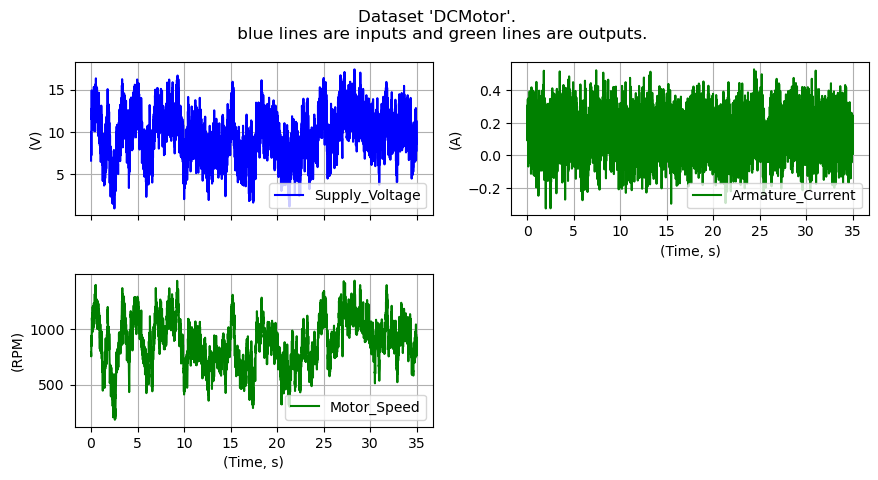

In [8]:
_= ds.plot()

...and let's check its coverage.

/home/yt75534/dymoval/src/dymoval/dataset.py:1752: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


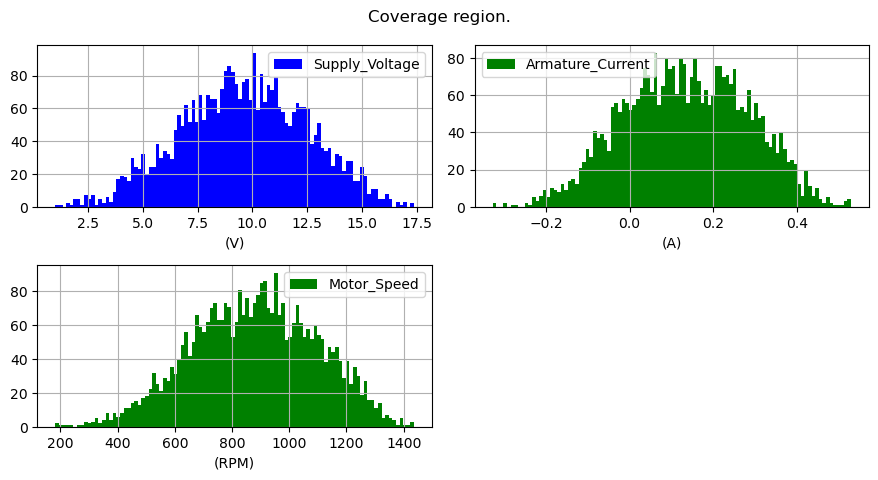

In [9]:
_= ds.plot_coverage()

The datset is not bad, but the measurements are a bit noisy, so we clean them up a little bit through a low pass filter. But hey! How to choose the cutoff frequency of the filter?

Well, we can perform a spectral analysis.
We plot the spectrum through the method `plot_spectrum()` but before we remove the continuous component through the `remove_means()` method:

/home/yt75534/dymoval/src/dymoval/dataset.py:2259: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


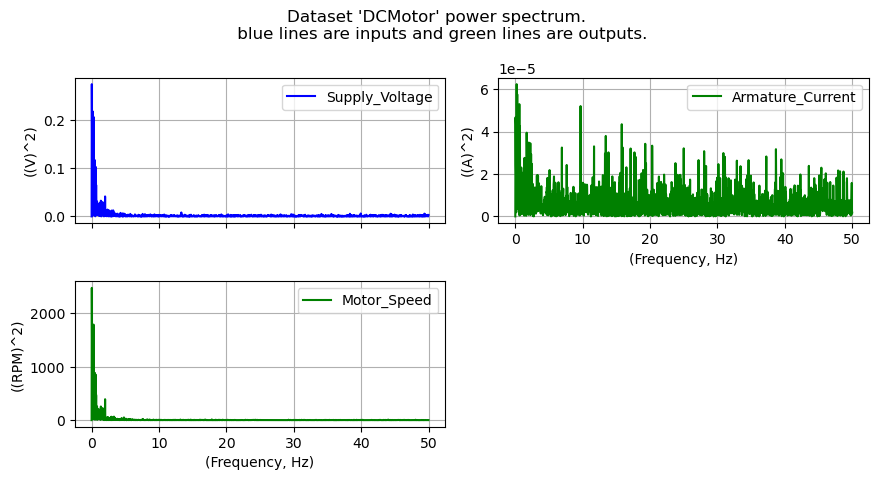

In [10]:
_= ds.remove_means().plot_spectrum()


The signals bandwidth of two over three signals is in contained very a narrow range $f < 1\, Hz$ with the exception of the current `i_a` signal. We can low-filter the "Supply_Voltage" and the "MotorSpeed" signals whereas we keep the "Current" signal as is.

To avoid losing transient information, we stay a bit larger than $1\, Hz$. We choose a cutoff frequency $f_c = 5\, Hz$.

/home/yt75534/dymoval/src/dymoval/dataset.py:1602: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


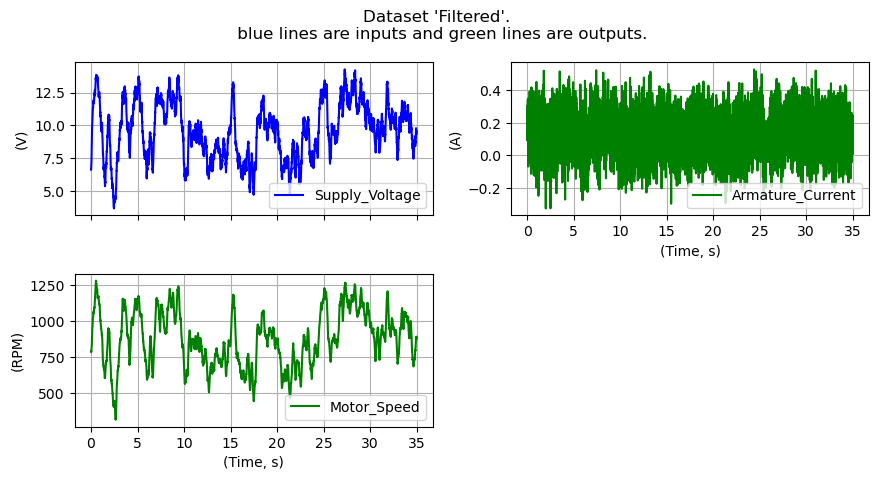

In [11]:
cutoff = 10  # [Hz]
ds_filt = ds.low_pass_filter(('Supply_Voltage', cutoff),('Motor_Speed', cutoff))
ds_filt.name = "Filtered"
_= ds_filt.plot()

Let's compare our datasets before and after the filtering. 

/home/yt75534/dymoval/src/dymoval/dataset.py:1602: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/yt75534/dymoval/src/dymoval/dataset.py:1602: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


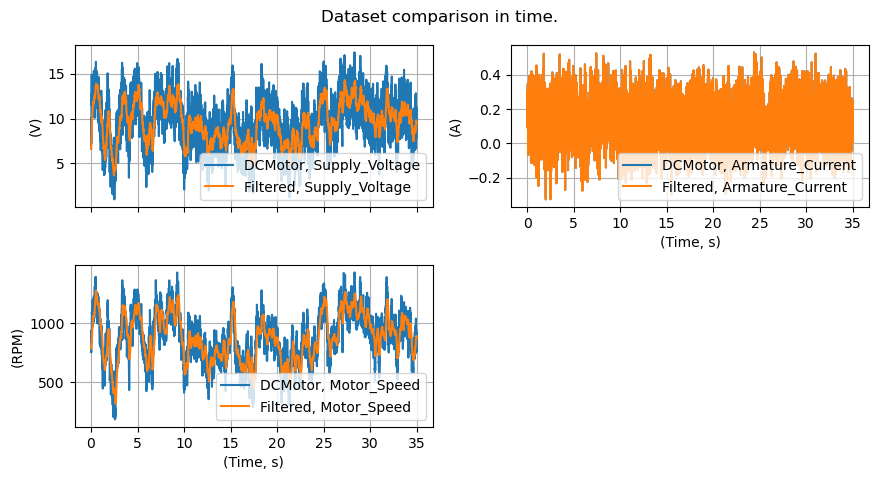

In [12]:
_= dmv.compare_datasets(ds,ds_filt)

The chosen cutoff frequency seems to clean up most of the noise and at the same time it does not intoduce too much lag.

Let's take a look how the coverage is affected.

/home/yt75534/dymoval/src/dymoval/dataset.py:1752: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


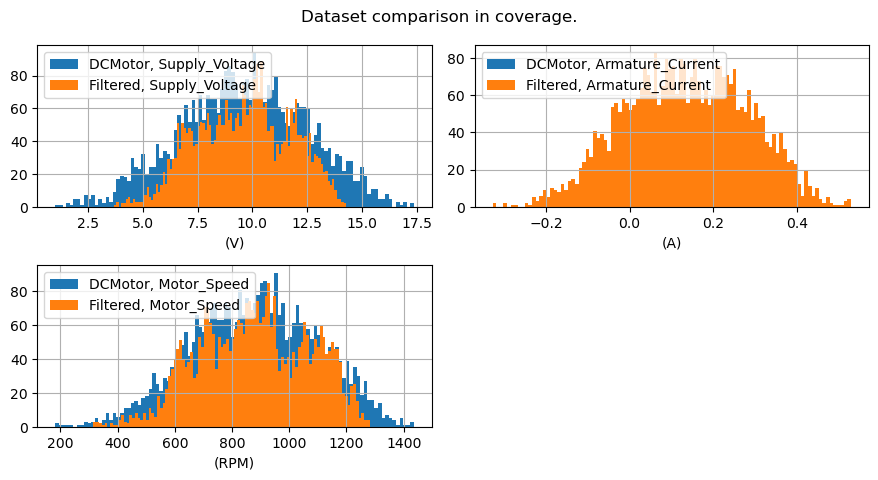

In [13]:
_= dmv.compare_datasets(ds,ds_filt, kind="coverage")

The coverage is pretty much the same, which means that we managed to remove noise without affecting the coverage region.


Only for the sake of showing more Dymoval features, we can selectively choose the signals that we want to plot or we can overlap them if we pass them as a tuple:

/home/yt75534/dymoval/src/dymoval/dataset.py:1602: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


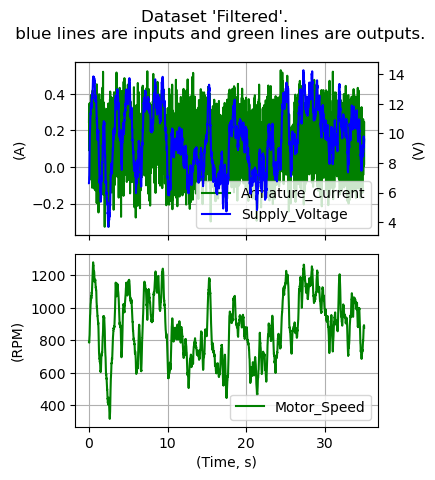

In [14]:
_= ds_filt.plot(("Armature_Current", "Supply_Voltage"),"Motor_Speed")

Last thing lasl *DETREND*

/home/yt75534/dymoval/src/dymoval/dataset.py:1602: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/yt75534/dymoval/src/dymoval/dataset.py:1602: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


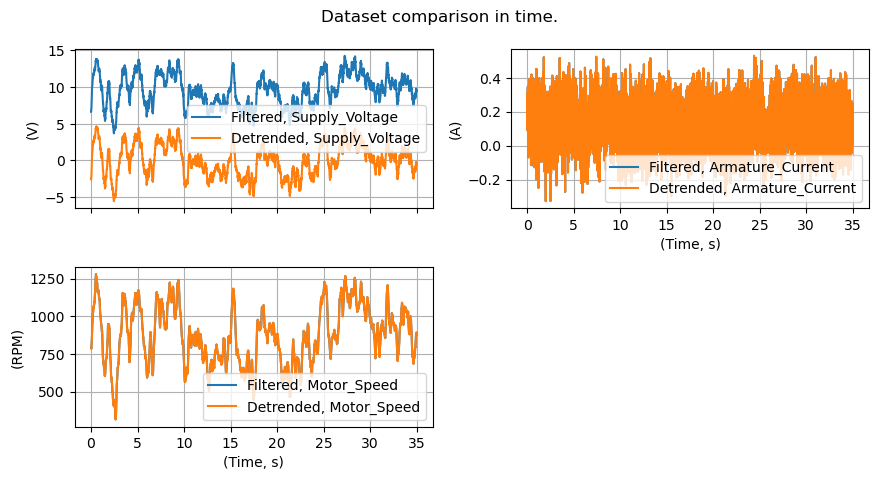

In [15]:
#ds_detrend = ds_filt.remove_means("Supply_Voltage").detrend("Supply_Voltage")
#ds_detrend.name = "Detrended"
#_= ds_detrend.plot(("Current", "Supply_Voltage"),"MotorSpeed")
#_=dmv.compare_datasets(ds_filt, ds_detrend)

## Validation Session

Now that we have:

- cleaned-up measurements stored in a dymoval *Dataset* object,
- a DC motor model.

Time to validate it! The only missing ingredient are the *simulated outputs* obtained by feeding our model with the cleaned-up input data stored in the *Dataset* object `ds_filt`.  


We first extract the cleaned up measurement numerical values:

In [16]:
(t,u,y) = ds_filt.dataset_values()

Then, we load our model and we feed it with the extracted input `u` and then we store the model response to a variable `y_sim`. Given that we have an FMU of our model, we use it for generating simulated outputs:

In [17]:
from  DCMotorModel import DCMotor_dt
import control as ct

# Simulate model
res = ct.forced_response(DCMotor_dt, X0=[0.0, 0.0, 0.0], U = u)
y_sim = res.y.T
print(y_sim)

[[  0.       0.    ]
 [  1.1484 522.0764]
 [  0.1989 597.0616]
 ...
 [  0.1195 859.1615]
 [  0.1151 851.6971]
 [  0.1631 866.4873]]


We now have all the ingredients to validate out models: we have input and output cleaned up measurements, we have a model and we have the simulated outputs. 

In [18]:
measured_signals_filtered = ds_filt.dump_to_signals()
measured_signals = ds_detrend.dump_to_signals()
measured_in = measured_signals['INPUT']
measured_out = measured_signals['OUTPUT']
sampling_period = measured_in[0]['sampling_period']

vs = dmv.validation.validate_models(measured_in=measured_in,measured_out=measured_out,simulated_out=[y_sim], sampling_period=sampling_period)
vs


Validation session name: quick & dirty

Validation setup:
----------------
Inputs auto-correlation
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Residuals auto-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Input-residuals cross-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Validation results:
-------------------
Thresholds: 
Input whiteness (mean-max): 0.6 
Input whiteness (quadratic-max): 0.6 
R-Squared (%): 65.0000 
Residuals whiteness (mean-max): 0.5000 
Residuals whiteness (quadratic-max): 0.5000 
Input-Res whiteness (mean-max): 0.5000 
Input-Res whiteness (quadratic-max): 0.5000 

Actuals:
                                      Sim_0
Input whiteness (mean-max)           0.8765
Input whiteness (quadratic-max)      0.7749
R-Squared (%)                       95.3348
Residuals 

As you see our model failed the test. 

I guess you are now wondering what is that `vs` object returned by `validate_models` function.
Well, a `ValidationSession` object contains the measurement dataset used for the validation, it contains all the simulation results passed through the argument `simulated_out` and all the validation's outcomes along with the various settings. 

Let's take a deeper look to why the test failed by looking at the `ValidationSession` object `vs`


In [19]:
vs

Validation session name: quick & dirty

Validation setup:
----------------
Inputs auto-correlation
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Residuals auto-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Input-residuals cross-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Validation results:
-------------------
Thresholds: 
Input whiteness (mean-max): 0.6 
Input whiteness (quadratic-max): 0.6 
R-Squared (%): 65.0000 
Residuals whiteness (mean-max): 0.5000 
Residuals whiteness (quadratic-max): 0.5000 
Input-Res whiteness (mean-max): 0.5000 
Input-Res whiteness (quadratic-max): 0.5000 

Actuals:
                                      Sim_0
Input whiteness (mean-max)           0.8765
Input whiteness (quadratic-max)      0.7749
R-Squared (%)                       95.3348
Residuals 

Let's focus on the *Validation results* section. 
A model is "good" if the whiteness levels are nearby 0.0 and the R-squared value is as high as possible. 
The validation process simply consists in comparing these values with some thresolds and then decide if the model is good to go or not.
You can set such thresholds depending on how stringent you want to be with your model at inizialization time of the `ValidationSession` object. 

Typically (but not always) the whiteness level used in a `ValidationSession` object are between 0 and 1 aand therefore the values of the thresholds should be somewhere in that interval.

The `simulated_models()` sets some default values for those thresholds as you can see above.

As we can see, the test didn't pass because of the value of `Input whiteness (mean-max)` which is `0.9568` whereas the threshold is set to the value of `0.6` (Note: the default threshold can be overriden, see docs).

What does it mean?

Well, that means that lab experiments could have been done better. In-fact, for model validation purposes, it is desirable that the real system "hits every corner" while logging data, which means that the input signal shall vary "as randomly as possible in an uncorrelated way". The whiteness level gives an indication of how that happened. 

However, there are many cases in which it is not possible to do harshly stimulate a system otherwise we may put equipment or people in danger, or it may just be too expensive, and we have to accept a high level of whiteness of the input data. 
The best thing to do in these cases is to exclude the input whiteness checks and validate our model only based on the outputs. This can be done by setting the `ignore_input` argument to `True` when we invoke the `validate_models()` function:

In [20]:
vs = dmv.validation.validate_models(measured_in=measured_in,measured_out=measured_out,simulated_out=[y_sim],ignore_input=True, sampling_period=sampling_period)

vs

Validation session name: quick & dirty

Validation setup:
----------------
Input ignored: True

Residuals auto-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Input-residuals cross-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Validation results:
-------------------
Thresholds: 
R-Squared (%): 65.0000 
Residuals whiteness (mean-max): 0.5000 
Residuals whiteness (quadratic-max): 0.5000 
Input-Res whiteness (mean-max): 0.5000 
Input-Res whiteness (quadratic-max): 0.5000 

Actuals:
                                      Sim_0
R-Squared (%)                       95.3348
Residuals whiteness (mean-max)       0.3495
Residuals whiteness (quadratic-max)  0.1803
Input-Res whiteness (mean-max)       0.0635
Input-Res whiteness (quadratic-max)  0.0067

         Sim_0  
Outcome: PASS   

As we can see, the model now passed the test!

The conclusion is that our model is thrustworthy as long as we use it in the coverage region that we showed before. The only thing that we need to keep in mind is that the validation has been done with a dataset that could have been richer.   

But what if things go very wrong?
Well, the ValidationSession class gives us a number of tools to get further insights of our model. We could for example plot the simulated outputs agains the measured outputs:

/home/yt75534/dymoval/src/dymoval/validation.py:1582: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


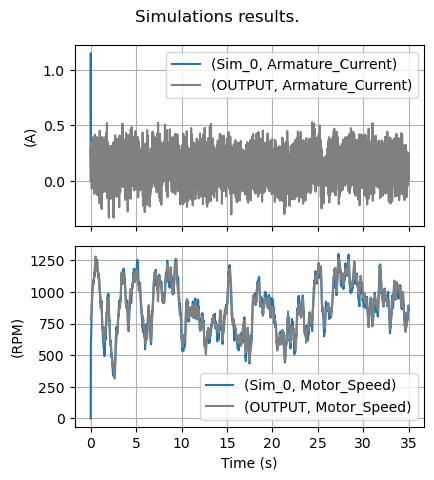

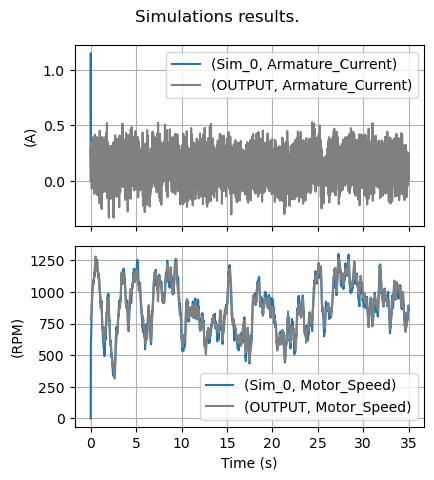

In [21]:
vs.plot_simulations(dataset='out')

/home/yt75534/dymoval/src/dymoval/validation.py:1902: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/yt75534/dymoval/src/dymoval/validation.py:1903: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/home/yt75534/dymoval/src/dymoval/validation.py:1904: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


(<Figure size 444.5x305 with 1 Axes>,
 <Figure size 889x485 with 4 Axes>,
 <Figure size 889x305 with 2 Axes>)

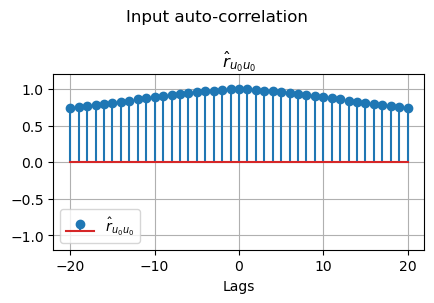

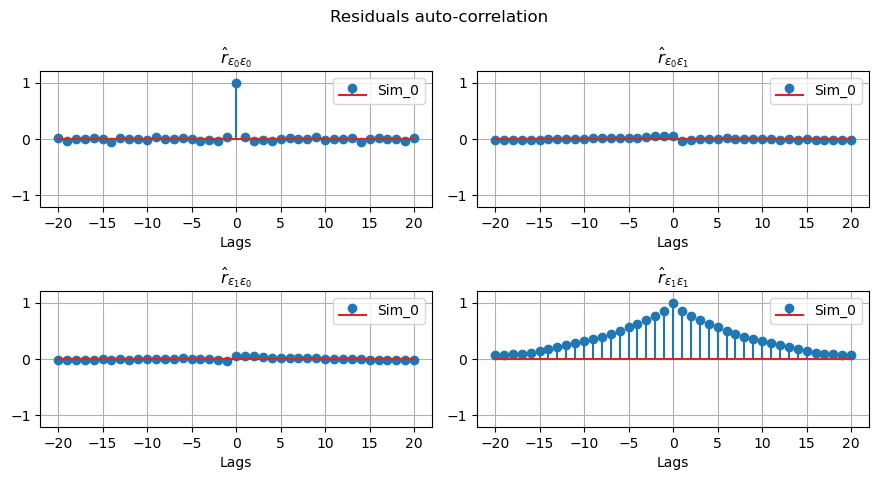

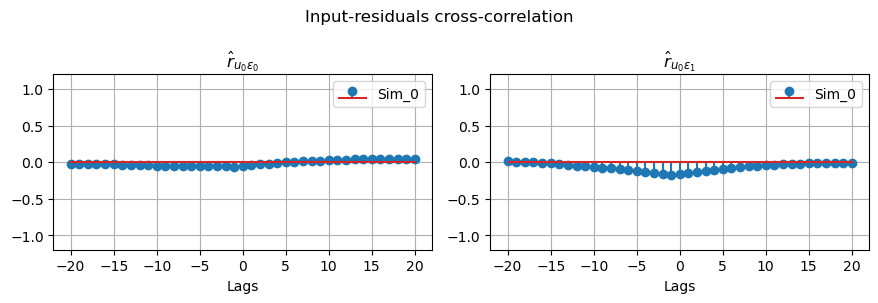

In [22]:
vs.plot_residuals()

The measured and simulated outputs overlap almost perfectly, as that is also explained by the high value of the r-squared that we have seen before.

Howver, there is a mismatch around t = 0.
That is something subtle that we try to explain. 
The considered dataset only includes the logged steady-state value of the real system (we trim the dataset around 30s, the motor was already in steady state at that time), whereas we simulated the model starting from a certain initial condition (= 0). Hence, around t = 0 we are comparing real system steady-state with model transient and that explains the mismatch in the time-plot of the simulations results versus the measurement data around t = 0. 

To overcome this issue, we can trim the validation dataset, thus excluding the portion around t = 0. In this way we compare real system steady-state VS model steady-state: 

/home/yt75534/dymoval/src/dymoval/validation.py:1582: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


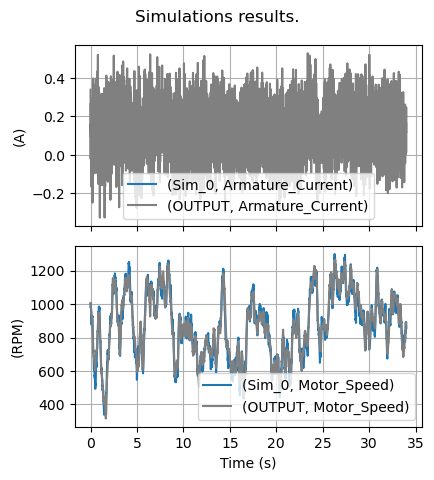

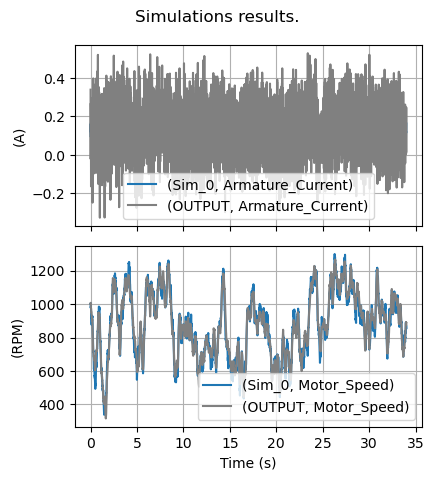

In [23]:
# trim the validation dataset between 1 and 35 seconds
vs = vs.trim(1,35)
vs.plot_simulations(dataset="out")

The plots look much better. 

Note that by trimming the measurements, the evaluation metric also changed. In-fact the r-squared index increased:

In [24]:
vs

Validation session name: quick & dirty

Validation setup:
----------------
Input ignored: True

Residuals auto-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Input-residuals cross-correlation:
1st statistic: mean-max
2nd statistic: quadratic-max
local weights: None
global weights: None
num lags: 41

Validation results:
-------------------
Thresholds: 
R-Squared (%): 65.0000 
Residuals whiteness (mean-max): 0.5000 
Residuals whiteness (quadratic-max): 0.5000 
Input-Res whiteness (mean-max): 0.5000 
Input-Res whiteness (quadratic-max): 0.5000 

Actuals:
                                      Sim_0
R-Squared (%)                       95.8455
Residuals whiteness (mean-max)       0.3915
Residuals whiteness (quadratic-max)  0.2193
Input-Res whiteness (mean-max)       0.0675
Input-Res whiteness (quadratic-max)  0.0071

         Sim_0  
Outcome: PASS   

Nevertheless, the whiteness levels got slighly worst, why? 
To explain it, we should introduce the concept of residuals. The residuals $\varepsilon$ are nothing more and nothing less than the error between the measured outputs and the simulated outputs defined as $\varepsilon = y_{measured}-y_{simulated}$. It is desirable that the residuals are as white as possible, which means that their auto-correlation values, for each outputs pair, is as close as possible to 0.0. 

Let's take a visual inspection:

/home/yt75534/dymoval/src/dymoval/validation.py:1902: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/home/yt75534/dymoval/src/dymoval/validation.py:1903: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/home/yt75534/dymoval/src/dymoval/validation.py:1904: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


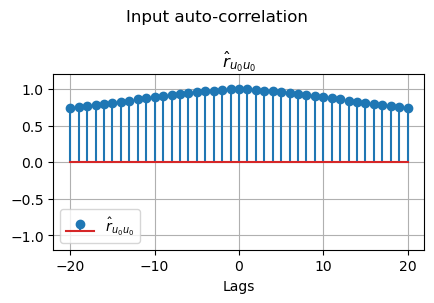

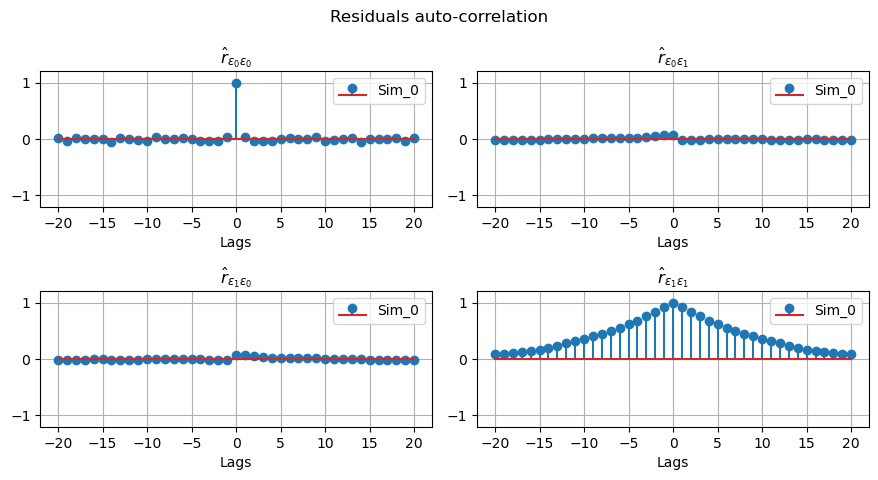

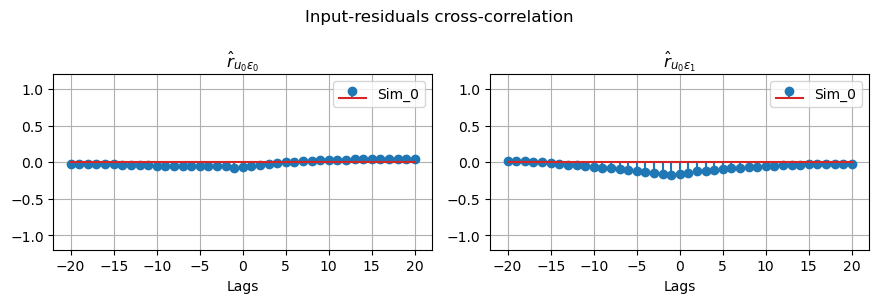

In [25]:
_ = vs.plot_residuals()

As we can see, the input signal autocorrelation is not super-white which reflect why our model failed the test in first instance. 

The other look excellent. That reflects how the whiteness level reported by our analysis is way below the acceptance thresholds that we set. 

Another interesting thing of the residuals is that they can pinpoint where the model needs improvement. 
In our case, although the model looks very good, if we really really want to improve it, we should focus in working more in the part that model the motor speedsince we have higher values of the residuals for that output.  

We finished our validation exercise. 
Our model looks great! The fit in terms or r-squared looks excellent and the residuals norms are also excellent. However, you should not forget that your model **is reliable only on its validation region**. If you plan to use it outside the validation region, you shall consider logging measurements in such a region and re-validate your model against the new measurement dataset. And, once you are there, try to "hit more corners". ;-) 

##  Finally remarks 

#### Results interpretation. 

High values of r-squared do not say no much about your model (but low values do send you a clear message!), but you should always check the residuals as well.
The tractation of why you should check your residuals goes beyond this tutorial but there are lot of very good explanations in the web or, even better, on some System Identification book. 

By default, the `simulate_models()` function (and consequently the derived `ValidationSession` object) computes both the mean and a quadratic form for each input-input, input-output and output-output pair of the residuals. The mean value indicates if the system dynamics are adequately modeled. That is, a high value indicates that some dynamics are not modeled whereas they should. The quadratic form gives an general overview of the amount of the residuals being outside a band around 0.0, this giving us hints on how white the signal under examinatios is. 

Given that most of the time we deal with MIMO systems, the results for each input-input, input-output and output-output pair are arranged in a $p\times q$ matrix - being $p$ the number of inputs and $q$ the number of outputs, and the worst case (max) of such result is taken, thus ultimately providing an overall evaluation value. 






#### A note
Dymoval is build to simplify common tasks that an engineer has to carry out and who may find tools such as pandas, matplotlib, numpy, etc. a bit too overwhelming.
However, if you need more power, consider that

1. Every plot returns a *matplotlib* figure, which means that you can further manipulate such a figure through the *matplotlib* API.
2. If you need to do further manipulate youd dataset and *dymoval* won't provide you certain functionalities, the you can use the method `dump_to_signals()` to dump the all the signals stored in the `Dataset` instance into a list of `Signals`. At this point you could use any packages you want (e.g. *numpy*, *scipy*, etc.) to manipulate the signals and then you may want to instantiate a brand new `Dataset` object from the manipulated signals.  


#### Another note
When manipulating `Dataset` or `ValidationSession` object, Dymoval won't change the current instance, but it returns a modified copy of it.
This means that e.g. `ds.remove_means()` won't change `ds` but you should explicitely re-assign it, e.g. `ds = ds.remove_means()`.


#### A third note
The main objects of *dymoval* are 

1. Signals, 
2. Datasets and 
3. ValidationSessions.

`Signals` are used as entry point from the external world to *dymoval*. We tried to keep them be as generic as possible.
`Datasets` are built upon *pandas* `DataFrames`. In-fact, the attribute `Dataset.dataset` is a pandas `DataFrame`:

In [26]:
ds_filt.dataset

kind               INPUT           OUTPUT            
names     Supply_Voltage Armature_Current Motor_Speed
units                  V                A         RPM
(Time, s)                                            
0.0000            6.6304           0.2462    790.0414
0.0100            6.6304           0.3070    790.0414
0.0200            6.9707           0.0912    789.1885
0.0300            7.0867           0.2771    785.6286
0.0400            7.1028           0.1183    801.1263
...                  ...              ...         ...
34.9600           9.4649           0.2376    889.0500
34.9700           9.3987           0.0062    891.7544
34.9800           9.3142           0.1161    886.7599
34.9900           9.5152           0.2473    890.8147
35.0000           9.5822           0.0173    877.4335

[3501 rows x 3 columns]

This means that in principle, you could use all the pandas `DataFrame` methods in dymoval.
However, although this can be useful in many casest, directly changing the values of a `Dataset.dataset` `DataFrame` is discouraged since a dymoval `Dataset` object has additional attributes such as coverage regions, *NaN* intervals, excluded signals and so on, that depends on the `dataset` attribute itself. Therefore, you may use the `dump_to_signals()` method as described in the **Note 1**, manipulate your signals and then create a new `Dataset` object.


In the same way, a *pandas* DataFrame is a `Dataset` object, then a `Dataset` object is an attribute of a `ValidationSession`:

## What's next?

Feel free to check the [documentation](https://volvogroup.github.io/dymoval/) to have access to the full API and to get more insight on how *dymoval* is structured.

Good luck!

# Credits
Picture from Mika Baumeister on Unsplash.